7/1/2019

So, I currently have a trained character-level s0 model, and now I'm going to build a version of Reuben's incremental RSA on top of it, implementing the equations in the cell below. Additionally, this notebook implements beam search and  a likelihood function (that gives the probability assigned to an utterance given a context). Finally, the RSA class itself has method for displaying probabilities assigned by different levels of the pragmatic recursion (s0, l0, s1).


TODO: 
- standardize the way that distributions are passed around. From beam search, I'm just returning a list of tuples, but for the context colors I have a "distribution" object.
- change the beam search implementation in the LiteralSpeaker model in models.py

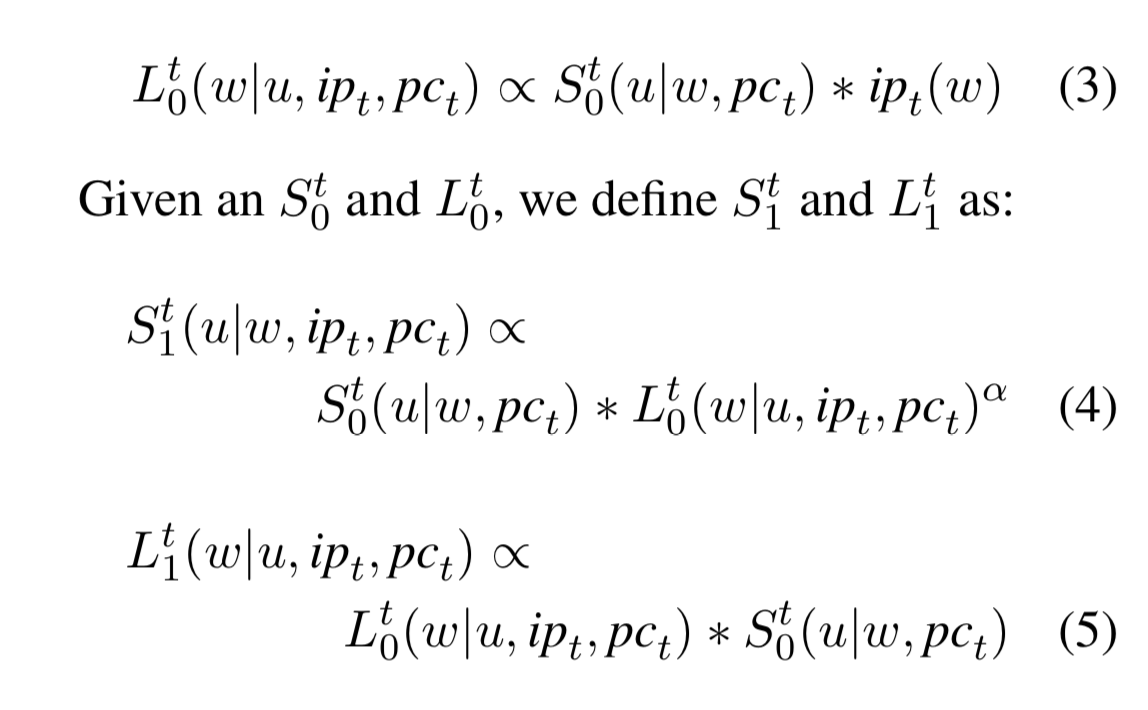

In [41]:
import sys
sys.path.append("..")

In [317]:
from monroe_data import MonroeData, MonroeDataEntry, Color # for loading in training data
import caption_featurizers                              # for getting caption representations
import color_featurizers                                # for getting color representations
from experiment import FeatureHandler                   # for combining caption and color features

from models import PytorchModel, LiteralSpeakerScorer         # model base that handles training / evaluation
from models import CharacterCaptionGenerator, BeamNode



In [91]:
import numpy as np
import scipy.special
from queue import PriorityQueue
from sklearn.feature_extraction import DictVectorizer

In [1351]:
import importlib
import monroe_data
importlib.reload(monroe_data)
from monroe_data import MonroeData, MonroeDataEntry, Color

In [1352]:
# so we can recreate vocabulary
train_data = MonroeData("../data/csv/train_corpus_monroe.csv", "../data/entries/train_entries_monroe.pkl")
#dev_data = MonroeData("../data/csv/dev_corpus_monroe.csv", "../data/entries/dev_entries_monroe.pkl")

In [50]:
# set up caption featurizer with same vocab as with training
caption_phi = caption_featurizers.CaptionFeaturizer(tokenizer = caption_featurizers.CharacterTokenizer)
caption_phi.construct_featurizer(train_data)

In [44]:
def wordify(idx_array):
    return "".join([caption_phi.caption_indexer.get_word_from_idx(i) for i in idx_array[0]])


In [134]:
# from Chris' code
def rownorm(mat):
    """Row normalization of np.array or pd.DataFrame"""
    return (mat.T / mat.sum(axis=1)).T

def rownormlog(mat):
    """Row normalization in log space"""
    return (mat.T - scipy.special.logsumexp(mat, axis=1)).T

In [747]:
# from Chris' code
def safelog(vals):
    """Silence distracting warnings about log(0)."""
    with np.errstate(divide='ignore'):
        return np.log(vals)


In [1421]:
class RSA:
    
    def __init__(self, rationality, passing_priors = False):
        self.rat = rationality
        
        self.s0_cache = {}
        
        # set up fourier model
        self.model_fourier = LiteralSpeakerScorer(CharacterCaptionGenerator, max_gen_len=40)
        self.model_fourier.init_model(color_in_dim=54, color_dim=50, vocab_size=caption_phi.caption_indexer.size,
                               embed_dim=50, speaker_hidden_dim=100)
        self.model_fourier.load_model("../model/character_literal_speaker.params")
        
        self.vocab_list = [caption_phi.caption_indexer.get_word_from_idx(i) 
                           for i in range(caption_phi.caption_indexer.size)]
        
        self.passing_priors = passing_priors
        
        
        
        
    def s0(self, previous_tokens, context):
        """
        returns distribution over next tokens for each context. This is where all the magic happens
        """
        
        # shape inputs into format required for predict function
        
        # add eos token to get actual probabilities
        eos_idx = caption_phi.caption_indexer.get_idx_from_word(caption_phi.caption_indexer.EOS)
        # the predict function expects a complete sentence, so we add eos_idx at the end
        
        s0_results = []
        for color in context.support:
                
            s0_result = self.model_fourier.predict([[previous_tokens + [eos_idx], [color]]])
            s0_result = s0_result[0]
            s0_results.append([t.numpy() for t in s0_result])
            
        
        s0_results = np.array(s0_results).reshape(len(context.support), len(previous_tokens), -1)
        return s0_results[:, -1, :] # only return choices for the next token
    
    def l0(self, context, previous_tokens):
        """
        returns distribution over contexts
        """
        if self.passing_priors: # if we are going to incrementally update the prior
            if len(previous_tokens) > 1: # i.e. if we have generated more than the start token
                w_priors = l0_probs_cache.T[previous_tokens[-1]]
            else:
                w_priors = context.probs
            
        
        s0_probs = self.s0(previous_tokens, context) # tokens x context matrix
        l0_probs = s0_probs.T + np.log(w_priors) # log space
        l0_probs = rownormlog(l0_probs)
        
        if self.passing_priors:
            l0_probs_cache = l0_probs
    
        return l0_probs
         
    
    def s1(self, previous_tokens, context):
        """
        returns distribution over next tokens
        """
        s0_probs = self.s0(previous_tokens, context)
        l0_probs = self.l0(context, previous_tokens)
        l0_probs = l0_probs * self.rat # log space
        s1_probs = s0_probs + l0_probs.T # log space
        return rownormlog(s1_probs)    
    
    
    def display_speakers(self, previous_tokens, context, dists="all", targets=[0, 1]):
        """
        dists is a list containing some subset of [s0, s1]
        targets is list containing indices of colors are targets [0, 1]
        
        returns a pandas dataframe for efficiently viewing all the speaker probabilities at once
        """
        viz_dict = {"chars": self.vocab_list}
        
        if dists == "all":
            dists = ["s0", "s1", "l0"]
            
        for dist in dists:
            if dist not in ("s0", "s1", "l0"):
                continue
            
            if dist == "l0":
                for target in targets:
                    viz_dict[f"{dist}_t{target}"] = np.exp(self.__getattribute__(dist)(context, previous_tokens).T[target]*self.rat)  
            else:
                for target in targets:
                    viz_dict[f"{dist}_t{target}"] = np.exp(self.__getattribute__(dist)(previous_tokens, context)[target])
                            
        return pd.DataFrame(viz_dict)
        

In [1422]:
rsa_test = RSA(rationality=0.5)
rsa_test_unit_rational = RSA(rationality=1)
rsa_test_dos_rational = RSA(rationality=2)
rsa_test_semi_rational = RSA(rationality=5)
rsa_test_rational = RSA(rationality=10)
rsa_test_uber_rational = RSA(rationality=20)

In [1242]:
rsa_test_probs = rsa_test_rational.display_speakers(['s0', 's1'], [0, 1], [0], context_dist)
rsa_test_probs.sort_values('s1_t1', ascending=False)

,chars,s0_t0,s0_t1,s1_t0,s1_t1
9,b,1.230442e-01,1.755889e-01,1.170657e-02,4.452959e-01
23,s,1.269739e-02,2.194745e-02,3.746365e-04,1.173274e-01
19,g,5.172326e-01,4.470863e-01,6.878188e-01,1.053559e-01
6,a,6.354656e-03,1.175743e-02,1.211891e-04,8.022553e-02
10,l,1.712784e-01,1.626122e-01,1.458221e-01,6.269059e-02
2,h,1.159153e-02,1.656289e-02,1.094506e-03,4.222720e-02
5,d,2.429255e-02,2.948810e-02,5.795350e-03,3.718904e-02
13,n,2.770319e-02,3.021744e-02,1.171200e-02,2.317726e-02
7,r,1.173336e-03,2.232986e-03,1.861766e-05,1.680544e-02
1,t,3.880919e-02,3.775424e-02,2.932261e-02,1.648048e-02


In [53]:
# For representing distributions
class Dist:
    def __init__(self, support, probs):
        self.support = support
        self.probs = probs

In [1238]:
def beam_search_r(rsa_agent, context, beam_width=1, max_gen_len=40, target_index=0, pragmatic=True):
    beam_nodes = PriorityQueue()
    
    utterance_so_far = [0]
    stop_token = caption_phi.caption_indexer.get_idx_from_word(caption_phi.caption_indexer.EOS)
    all_utterances = []
    
    
    # 1. á la Reuben, also begin by adding all bigrams to the queue (i.e. do a full search for the first two characters)
    
    # run the speaker
    speaker = rsa_agent.s1 if pragmatic else rsa_agent.s0
    next_token_probs = speaker(utterance_so_far, context)[target_index]
    
    for i in range(len(rsa_agent.vocab_list)):
        if i == stop_token: continue # we don't want to end after the first token
            
        bigram_probs = speaker(utterance_so_far + [i], context)[target_index]
        
        for j in range(len(rsa_agent.vocab_list)):
            bigram_log_prob = next_token_probs[i] + bigram_probs[j]
            bigram_utterance = utterance_so_far + [i, j]
            ending = (j == stop_token)
            beam_nodes.put(BeamNode(
                bigram_log_prob, bigram_utterance, ending)
            )
  

    # 2. Do the rest of the search with an actual beam search    
    done_with_search = False
    while not done_with_search:
        # get the `beam_width' most probable nodes from previous iteration
        candidate_nodes = []
        for i in range(beam_width):
            candidate_nodes.append(beam_nodes.get()) 
            
        # reset queue for next round
        beam_nodes = PriorityQueue()

        for likely_utterance_node in candidate_nodes:
            utterance_so_far = likely_utterance_node.tokens
            if likely_utterance_node.ended:
                all_utterances.append((utterance_so_far, likely_utterance_node.log_prob))
                if len(all_utterances) == beam_width:
                    done_with_search = True
                    break
            else:
                # run the speaker
                next_token_probs = speaker(utterance_so_far, context)
                    
                # we'll be able to take at most `beam_width' next tokens from any candidate node,
                # so let's only consider the top `beam_width' next tokens
                # Also: tokens are the indices
                top_k_next_tokens = np.argsort(next_token_probs[target_index])[-beam_width:] 

                # add each top potential next token to the beam_nodes queue
                for i in range(beam_width):
                    next_token = top_k_next_tokens[i]
                    next_token_log_prob = next_token_probs[target_index][next_token]
                    next_utterance_step = utterance_so_far + [next_token]
                    utterance_over = (next_token == stop_token or len(next_utterance_step) >= max_gen_len)

                    beam_nodes.put(BeamNode(likely_utterance_node.log_prob + next_token_log_prob,
                                   next_utterance_step,
                                   ended=utterance_over))
        
    # Remove sos and eos tokens. Normalize probabilities by length of utterance (not including start/end tokens)
    # Sort probabilities from largest to smallest
    ln_temp = 1 # temperature parameter for length-normalization
    all_utterances = [(tokens[1:-1], log_prob) for tokens, log_prob in all_utterances]
    all_utterances = [(wordify([tokens]), np.exp(log_prob / len(tokens)**ln_temp)) for tokens, log_prob in all_utterances]
    all_utterances = sorted(all_utterances, key=lambda utterance: utterance[1], reverse=True)
    return all_utterances


In [ ]:
def likelihood(rsa_agent, context, utterance, target_index=0, incomplete_utterance=False):
    utterance = caption_phi.to_string_features(utterance, construct=False)[1].tolist() # tolist because we need to append things to it in the agent.:(
    log_prob = 0
    for i in range(1, len(utterance) - (incomplete_utterance)): # don't include log-prob of prediction of the end token if the utterance is not finished
        next_token_probs = rsa_agent.s1(utterance[:i], context)
        log_prob += next_token_probs[target_index][utterance[i]]
    return log_prob

In [1265]:
# this is kind of weird, basically what we want to do is say that the k ways to refer to each of the colors forms the
# ``literal semantics" and then we can just do regular RSA with those. Importantly, these samples are obtained using
# incremental RSA already. 
def global_pragmatics(context, target_idx=0, rat=0.5):
    # first use beam search to get high-probability, pragamatic samples for each color. These form the semantics
    possible_captions = []
    for i in range(len(context.support)):
        possible_captions.append({})
        possible_caption_list = beam_search_r(rsa_test_unit_rational, context, beam_width=5, target_index=i)
        for pc, pc_prob in possible_caption_list:
            possible_captions[i][pc] = 1

    dv = DictVectorizer(sparse=False)
    semantics = dv.fit_transform(possible_captions)
    # now possible captions refers to the list of possible captions
    possible_captions = dv.get_feature_names()

    # get probabilities - this is kinda inefficient, but I'm pretty sure it's needed to get a complete prior over utterances
    # I guess it's not exactly a prior, so it might be ok to just get the probabilities from the beam search. That would
    # be more efficient (and I have to work on writing more concisely)
    target_log_probs = np.empty((len(context_dist.support), len(possible_captions)))
    for i in range(len(context.support)):
        for j, cap in enumerate(possible_captions):
            log_prob_per_token = likelihood(rsa_test, context, cap, target_index=i) / len(cap)
            target_log_probs[i][j] = log_prob_per_token

    # normalize probabilities of utterances to get prior over utterances
    speaker_priors = rownormlog(target_log_probs)
    
    s0_g = safelog(semantics) + speaker_priors
    l0_g = rownormlog(s0_g.T + safelog(context.probs))
    s1_g = rownormlog(0.5 * l0_g.T + s0_g)
    
    best_utterance_idx = np.argmax(s1_g[target_idx])
    return possible_captions[best_utterance_idx]
    

# Sample Contexts and Samples

In [1243]:
context_hsv = [[0, 1, 1], [1/3, 1,1], [2/3, 1, 1]]
context_fourier = [color_featurizers.color_phi_fourier(hsv, space="hsv_norm") for hsv in context_hsv]
context_dist = Dist(context_fourier, probs = [1/3, 1/3, 1/3])

beam_search_r(rsa_test, context_dist, beam_width=5)

[('red', 0.8445676709341112),
 ('red red', 0.628277318462921),
 ('red/red', 0.5883215780334511),
 ('orange', 0.5854225161334176),
 ('pink', 0.3570131024439365)]

In [1246]:
# red and orange (orange is lower)
context_hsv = [[0, 1, 1], [1/12, 1,1], [2/3, 1, 1]]
context_fourier = [color_featurizers.color_phi_fourier(hsv, space="hsv_norm") for hsv in context_hsv]
context_dist = Dist(context_fourier, probs = [1/3, 1/3, 1/3])

beam_search_r(rsa_test_unit_rational, context_dist, beam_width=5)

[('red', 0.8285208711730025),
 ('red red', 0.6784054543028807),
 ('red/red', 0.6135191241537725),
 ('red ~ red', 0.5272355345788631),
 ('red pink', 0.4880654058884585)]

In [372]:
# red and orange - not pragmatic (orange is lower)
context_hsv = [[0, 1, 1], [1/12, 1,1], [2/3, 1, 1]]
context_fourier = [color_featurizers.color_phi_fourier(hsv, space="hsv_norm") for hsv in context_hsv]
context_dist = Dist(context_fourier, probs = [1/3, 1/3, 1/3])

beam_search_r(rsa_test, context_dist, beam_width=5, pragmatic=False)

['<sos>red<eos>',
 '<sos>orange<eos>',
 '<sos>red red<eos>',
 '<sos>red/red<eos>',
 '<sos>redish<eos>']

In [1254]:
# two similar reds
context_hsv = [[0, 1, 1], [0.1, 1, 1], [2/3, 1, 1]]
context_fourier = [color_featurizers.color_phi_fourier(hsv, space="hsv_norm") for hsv in context_hsv]
context_dist = Dist(context_fourier, probs = [1/3, 1/3, 1/3])

beam_search_r(rsa_test_dos_rational, context_dist, beam_width=5)

[('red', 0.7750603271150498),
 ('red red', 0.7370830604781071),
 ('red red red', 0.733095224346429),
 ('red/red', 0.6168929345835877),
 ('red pink', 0.5080118748331991)]

In [1255]:
beam_search_r(rsa_test_dos_rational, context_dist, beam_width=5, target_index=1)

[('orange', 0.8885348331095854),
 ('yellow', 0.8035226869515403),
 ('orange orange', 0.7286941088933425),
 ('orange yellow', 0.7140472025323563),
 ('gold', 0.25147594097546255)]

In [366]:
# red and pink (pink is lower)
context_hsv = [[0, 1, 1], [305/360, 0.25,1], [2/3, 1, 1]]
context_fourier = [color_featurizers.color_phi_fourier(hsv, space="hsv_norm") for hsv in context_hsv]
context_dist = Dist(context_fourier, probs = [1/3, 1/3, 1/3])

beam_search(rsa_test, context_dist, beam_width=5)

['<sos>red<eos>',
 '<sos>orange<eos>',
 '<sos>red red<eos>',
 '<sos>red/red<eos>',
 '<sos>red orange<eos>']

In [371]:
# red and pink - nonpragmatic
context_hsv = [[0, 1, 1], [305/360, 0.25,1], [2/3, 1, 1]]
context_fourier = [color_featurizers.color_phi_fourier(hsv, space="hsv_norm") for hsv in context_hsv]
context_dist = Dist(context_fourier, probs = [1/3, 1/3, 1/3])

beam_search(rsa_test, context_dist, beam_width=5, pragmatic=False)

['<sos>red<eos>',
 '<sos>orange<eos>',
 '<sos>red red<eos>',
 '<sos>red/red<eos>',
 '<sos>redish<eos>']

In [373]:
# red and pink - nonpragmatic (pink target)
context_hsv = [[0, 1, 1], [305/360, 0.25,1], [2/3, 1, 1]]
context_fourier = [color_featurizers.color_phi_fourier(hsv, space="hsv_norm") for hsv in context_hsv]
context_dist = Dist(context_fourier, probs = [1/3, 1/3, 1/3])

beam_search(rsa_test, context_dist, beam_width=5, pragmatic=False, target_index=1) # target is pink

['<sos>pink<eos>',
 '<sos>purple<eos>',
 '<sos>red<eos>',
 '<sos>purp<eos>',
 '<sos>hot pink<eos>']

In [374]:
# red and pink - pragmatic (pink target)
context_hsv = [[0, 1, 1], [305/360, 0.25,1], [2/3, 1, 1]]
context_fourier = [color_featurizers.color_phi_fourier(hsv, space="hsv_norm") for hsv in context_hsv]
context_dist = Dist(context_fourier, probs = [1/3, 1/3, 1/3])

beam_search(rsa_test, context_dist, beam_width=5, pragmatic=True, target_index=1) # target is pink

['<sos>pink<eos>',
 '<sos>purple<eos>',
 '<sos>hot pink<eos>',
 '<sos>purp<eos>',
 '<sos>purple?<eos>']

In [735]:
# light and dark red
context_hsv = [[0, 0.5, 1], [0, 0.8, 0.8]]
context_fourier = [color_featurizers.color_phi_fourier(hsv, space="hsv_norm") for hsv in context_hsv]
context_dist = Dist(context_fourier, probs = [0.5, 0.5])

beam_search_r(rsa_test, context_dist, beam_width=5, pragmatic=False)

['red', 'orange', 'pink', 'orangish', 'redish']

In [1423]:
context_hsv = [[90/360, 1, 1], [100/360, 1, 1]]
context_fourier = [color_featurizers.color_phi_fourier(hsv, space="hsv_norm") for hsv in context_hsv]
context_dist = Dist(context_fourier, probs = [0.5, 0.5])


In [1424]:
beam_search_r(rsa_test_dos_rational, context_dist, beam_width=1)

UnboundLocalError: local variable 'w_priors' referenced before assignment

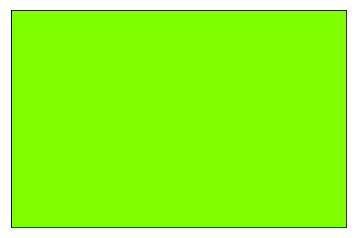

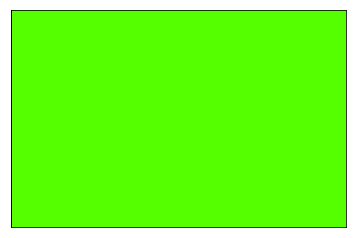

In [880]:
train_data.display_target(Color(90, 100, 50, space="hsl").rgb_norm, "")
train_data.display_target(Color(100, 100, 50, space="hsl").rgb_norm, "")

yellow


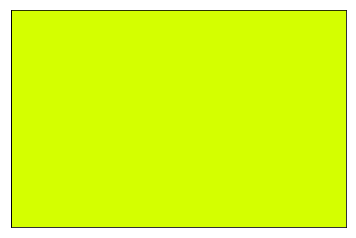

brightest


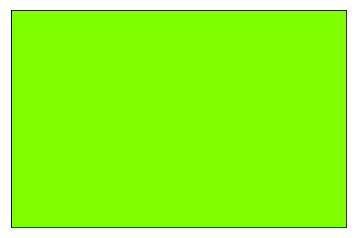

lime green


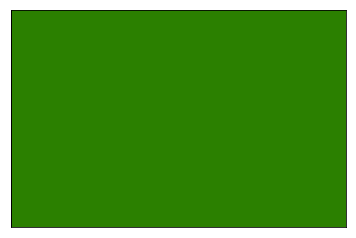

In [1274]:
train_data.display_target(Color(70, 100, 50, space="hsl").rgb_norm, "yellow")
train_data.display_target(Color(90, 100, 50, space="hsl").rgb_norm, "brightest")
train_data.display_target(Color(100, 100, 25, space="hsl").rgb_norm, "lime green")

In [1271]:
# two greens
context_hsv = [[90/360, 1, 1], [(90 + 10)/360, 1, 0.5], [70/360, 1, 1]]
context_fourier = [color_featurizers.color_phi_fourier(hsv, space="hsv_norm") for hsv in context_hsv]
context_dist = Dist(context_fourier, probs = [1/3, 1/3, 1/3])

global_pragmatics(context_dist)

'lightest green'

In [1272]:
global_pragmatics(context_dist, target_idx=1)

'gray green'

In [1273]:
global_pragmatics(context_dist, target_idx=2)

'yellow'

In [1275]:
# two blues
context_hsv = [[175/360, 1, 1], [(250)/360, 1, 0.5]]
context_fourier = [color_featurizers.color_phi_fourier(hsv, space="hsv_norm") for hsv in context_hsv]
context_dist = Dist(context_fourier, probs = [0.5, 0.5])

global_pragmatics(context_dist)

'bright blue'

In [1276]:
global_pragmatics(context_dist, target_idx=1)

'purple'

light blue


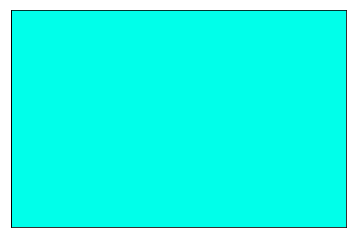

darker purple


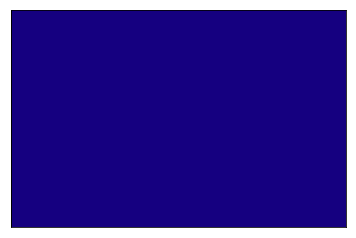

In [832]:
train_data.display_target(Color(175, 100, 50, space="hsl").rgb_norm, "light blue")
train_data.display_target(Color(250, 100, 25, space="hsl").rgb_norm, "darker purple")

In [1248]:
# two blues
context_hsv = [[175/360, 1, 1], [(250)/360, 1, 1]]
context_fourier = [color_featurizers.color_phi_fourier(hsv, space="hsv_norm") for hsv in context_hsv]
context_dist = Dist(context_fourier, probs = [0.5, 0.5])

#global_pragmatics(context_dist)

In [1250]:
beam_search_r(rsa_test_dos_rational, context_dist, beam_width=5)

[('turquoise', 0.6582978344464164),
 ('blue', 0.6501554678321216),
 ('blue ~ blue', 0.582130236487958),
 ('blue gold', 0.5652502232339082),
 ('blue/green', 0.5454808126594975)]

In [1251]:
beam_search_r(rsa_test_dos_rational, context_dist, beam_width=5, pragmatic=False)

[('blue', 0.7982072709740181),
 ('bright blue', 0.6549315325921625),
 ('blue ~ blue', 0.6131202885188478),
 ('blue blue', 0.5710613377716295),
 ('blue green', 0.5438875328989544)]

In [1252]:
beam_search_r(rsa_test_dos_rational, context_dist, beam_width=5, target_index=1)

[('blue', 0.8391365677782678),
 ('purple', 0.6864441634677698),
 ('bright blue', 0.6518320727080084),
 ('briget blue', 0.5811240691496483),
 ('bright', 0.42249457900059095)]

In [834]:
global_pragmatics(context_dist, target_idx=1)

'bright blue'

turquoise


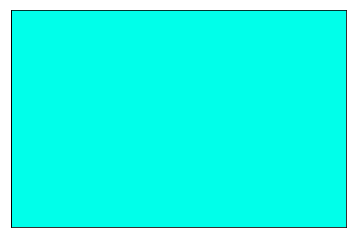

brighter blue


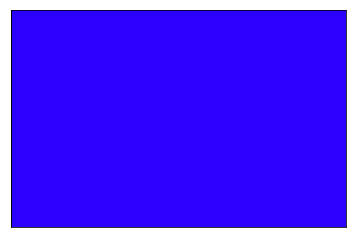

In [835]:
train_data.display_target(Color(175, 100, 50, space="hsl").rgb_norm, "turquoise")
train_data.display_target(Color(250, 100, 50, space="hsl").rgb_norm, "brighter blue")

In [1277]:
# two blues
context_hsv = [[175/360, 1, 0.75], [(250)/360, 1, 0.5]]
context_fourier = [color_featurizers.color_phi_fourier(hsv, space="hsv_norm") for hsv in context_hsv]
context_dist = Dist(context_fourier, probs = [0.5, 0.5])

print(global_pragmatics(context_dist))
print(global_pragmatics(context_dist, target_idx=1))

light blue
purple


In [1281]:
beam_search_r(rsa_test_unit_rational, context_dist, beam_width=5)

[('blue', 0.7074296639917823),
 ('bright blue', 0.6794150573348362),
 ('blue blue', 0.6486349135361215),
 ('light blue', 0.628483576590736),
 ('blue/blue', 0.6140903317159869)]

In [1280]:
beam_search_r(rsa_test_unit_rational, context_dist, beam_width=5, target_index=1)

[('purple', 0.7807129342783728),
 ('dark purple', 0.7195365473727119),
 ('light purple', 0.7154956807489555),
 ('blue', 0.6670386460213371),
 ('darker blue', 0.5971378117657045)]

In [1282]:
def get_context(rgb_list, prior=None, color_space="rgb"):
    colors = [Color(*rgb, space=color_space) for rgb in rgb_list]
    context_fourier = [color_featurizers.color_phi_fourier(color.hsv_norm, space="hsv_norm") for color in colors]
    if prior is None: # assume uniform
        prior = [1/len(colors) for _ in colors]
    return Dist(context_fourier, probs=prior), colors

    

In [1389]:
def global_viz(rgb_list, prior=None, color_space="rgb"):
    context, colors = get_context(rgb_list, prior, color_space)
    caps = [beam_search_r(rsa_test_dos_rational, context, target_index=i, beam_width=5)[0][0] for i in range(len(colors))]
    
    for i, color in enumerate(colors):
        train_data.display_target(color.rgb_norm, caps[i])

def global_viz2(rgb_list, prior=None, color_space="rgb", rsa_agent=rsa_test_dos_rational):
    context, colors = get_context(rgb_list, prior, color_space)
    caps = [beam_search_r(rsa_agent, context, target_index=i, beam_width=5)[0][0] for i in range(len(colors))]
    
    caps = "\t".join(caps)
    train_data.display_custom_game(colors, caps)
    

turquoise


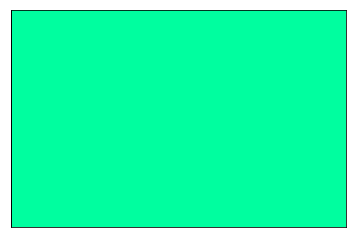

green


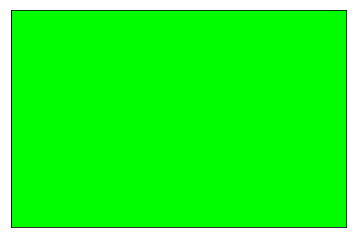

In [1297]:
global_viz([[0, 255, 160], [0, 255, 0]])

blue


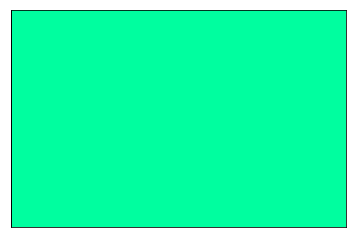

green


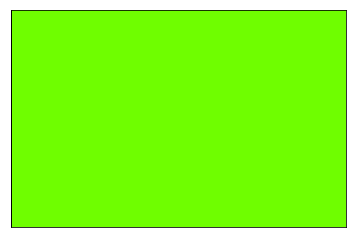

In [1298]:
global_viz([[0, 255, 160], [111, 255, 0]])

green


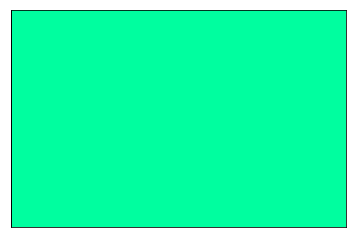

blue


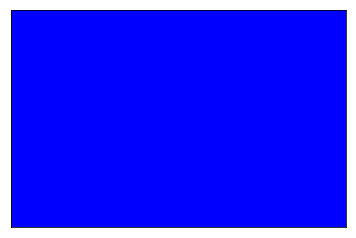

In [1300]:
global_viz([[0, 255, 160], [0, 0, 255]])

blue


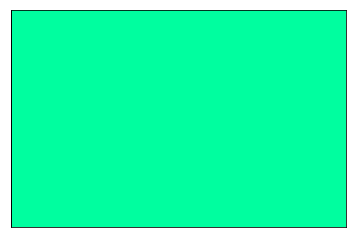

green


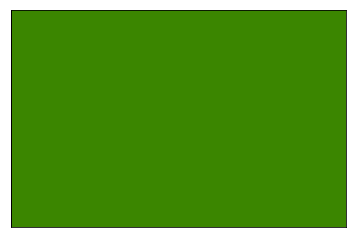

In [1301]:
global_viz([[0, 255, 160], [59, 135, 0]])

brightest green


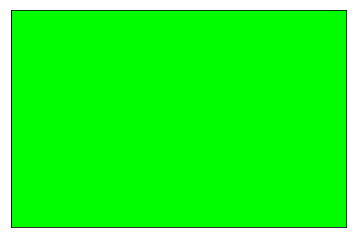

green


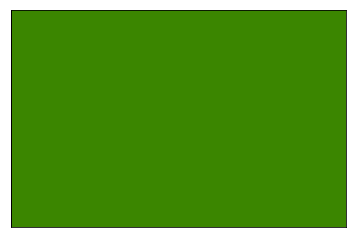

In [1302]:
global_viz([[0, 255, 0], [59, 135, 0]])

brightest green


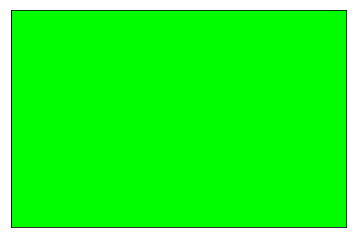

gray green


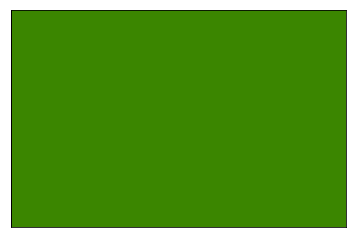

green


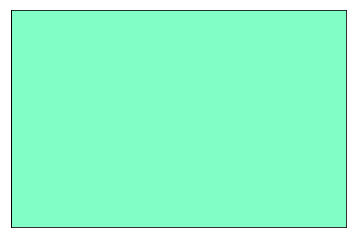

In [1331]:
global_viz([[0, 255, 0], [59, 135, 0], [128, 255, 198]])

brightest green


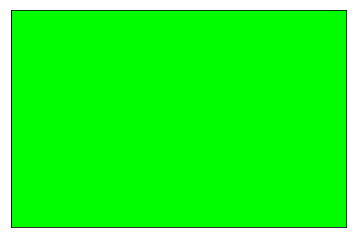

gray green


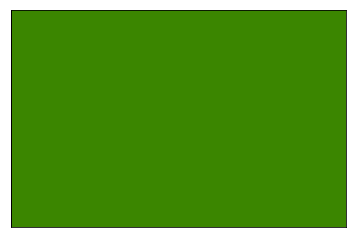

blue


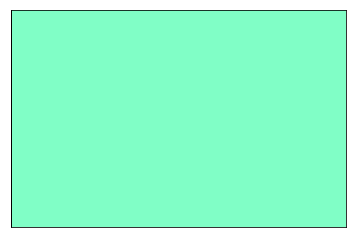

In [1330]:
global_viz([[0, 255, 0], [59, 135, 0], [128, 255, 199]])

brightest green


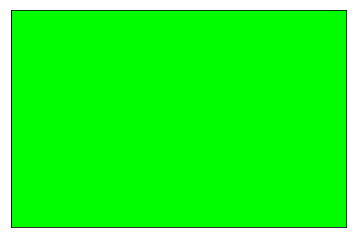

green


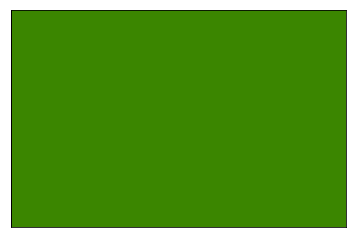

pink


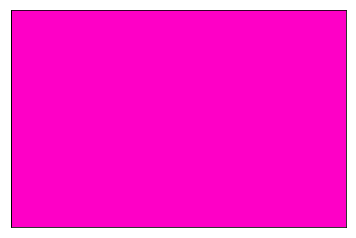

In [1332]:
global_viz([[0, 255, 0], [59, 135, 0], [255, 0, 199]])

[(-600, -400), (-200, -400)]
green	blue


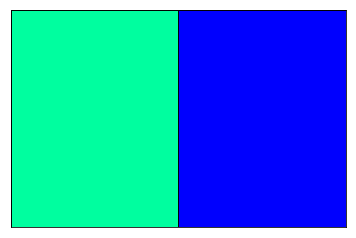

[(-600, -400), (-200, -400)]
blue	green


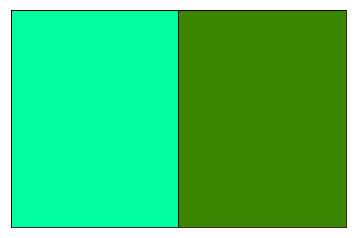

In [1416]:
global_viz2([[0, 255, 160], [0, 0, 255]])
global_viz2([[0, 255, 160], [59, 135, 0]])

purple


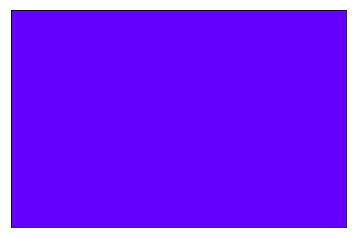

purple


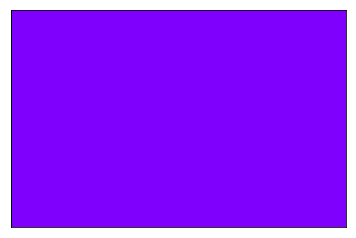

In [1360]:
global_viz([[100, 0, 255], [128, 0, 255], [255, 0, 199]])

purple


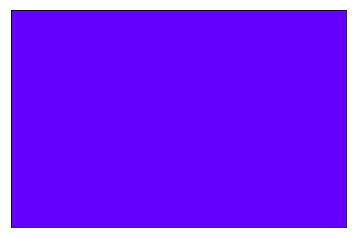

blue


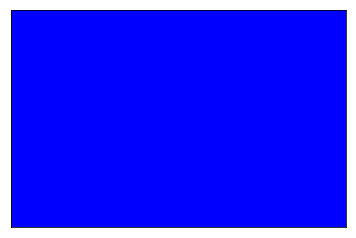

In [1336]:
global_viz([[100, 0, 255], [0, 0, 255]])

[(-600, -400), (-200, -400)]
purple	blue


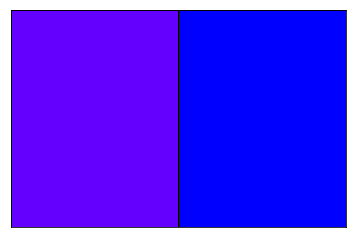

[(-600, -400), (-200, -400), (200, -400)]
blue	purple	pink


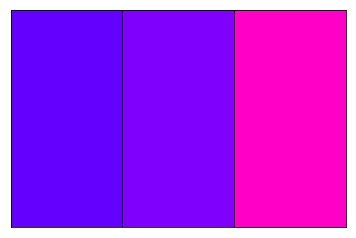

In [1361]:
global_viz2([[100, 0, 255], [0, 0, 255]]) # alpha = 2
global_viz2([[100, 0, 255], [0, 0, 255], [255, 0, 199]])

[(-600, -400), (-200, -400)]
purple	purple


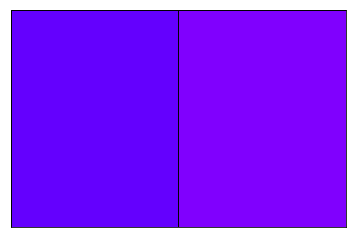

In [1362]:
global_viz2([[100, 0, 255], [128, 0, 255]])  # alpha = 2

[(-600, -400), (-200, -400)]
blue	purple


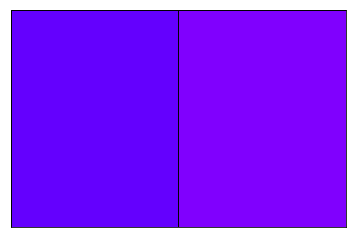

In [1390]:
global_viz2([[100, 0, 255], [128, 0, 255]], rsa_agent = rsa_test_tres_rational) # alpha = 3.5

[(-600, -400), (-200, -400)]
purple	blue


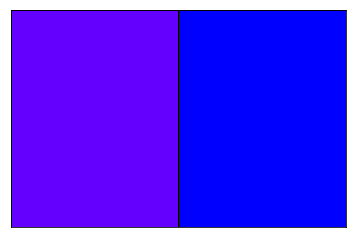

In [1413]:
global_viz2([[100, 0, 255], [0, 0, 255]]) # alpha = 2

In [1367]:
context_dist,_  = get_context([[100, 0, 255], [128, 0, 255]])

In [1400]:
rsa_test_tres_rational = RSA(rationality=3.5)

In [1375]:
beam_search_r(rsa_test_tres_rational, context_dist, beam_width=5)

[('blue', 0.7922972852463178),
 ('purple', 0.7736322944932165),
 ('purple purple', 0.714063151799953),
 ('light purple', 0.6669115823168764),
 ('light', 0.3989720740082691)]

In [1376]:
beam_search_r(rsa_test_tres_rational, context_dist, beam_width=5, target_index=1)

[('purple', 0.7664673122757913),
 ('purple pink', 0.7209967952110371),
 ('pink', 0.6442709627318767),
 ('darkest purp', 0.5725530906673273),
 ('purp', 0.4030660376851841)]

In [1414]:
rsa_test_dos_rational.display_speakers(context=context_dist, previous_tokens=[0]).sort_values('l0_t0', ascending=False)

,chars,l0_t0,l0_t1,s0_t0,s0_t1,s1_t0,s1_t1
49,3,0.631688,0.042112,1.308852e-07,3.379415e-08,3.043435e-07,5.286960e-09
41,2,0.601941,0.050244,7.710348e-06,2.227605e-06,1.708437e-05,4.157958e-07
42,&,0.469554,0.099074,3.473578e-09,1.595561e-09,6.003904e-09,5.872611e-10
3,e,0.468474,0.099571,5.344924e-04,2.464135e-04,9.217182e-04,9.114981e-05
40,*,0.463117,0.102063,1.496952e-05,7.027425e-06,2.551938e-05,2.664546e-06
45,<unk>,0.456519,0.105195,9.198703e-08,4.415649e-08,1.545813e-07,1.725636e-08
9,b,0.436123,0.115331,2.200699e-01,1.131695e-01,3.532972e-01,4.848806e-02
36,j,0.396152,0.137340,1.333210e-04,7.849927e-05,1.944159e-04,4.005172e-05
27,v,0.391213,0.140273,1.660681e-02,9.944123e-03,2.391499e-02,5.182023e-03
38,x,0.371140,0.152715,8.609491e-06,5.522679e-06,1.176212e-05,3.133222e-06


[(-600, -400), (-200, -400), (200, -400)]
purple	purple	red


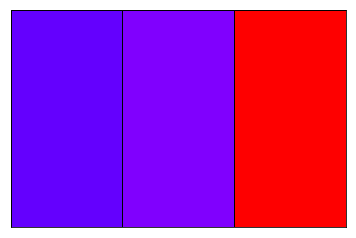

In [1392]:
global_viz2([[100, 0, 255], [128, 0, 255], [255, 0, 0]])

In [1417]:
rsa_test_dos_rational.display_speakers(context=context_dist, previous_tokens=[0]).sort_values('l0_t0', ascending=False)

,chars,l0_t0,l0_t1,s0_t0,s0_t1,s1_t0,s1_t1
49,3,0.631688,0.042112,1.308852e-07,3.379415e-08,3.043435e-07,5.286960e-09
41,2,0.601941,0.050244,7.710348e-06,2.227605e-06,1.708437e-05,4.157958e-07
42,&,0.469554,0.099074,3.473578e-09,1.595561e-09,6.003904e-09,5.872611e-10
3,e,0.468474,0.099571,5.344924e-04,2.464135e-04,9.217182e-04,9.114981e-05
40,*,0.463117,0.102063,1.496952e-05,7.027425e-06,2.551938e-05,2.664546e-06
45,<unk>,0.456519,0.105195,9.198703e-08,4.415649e-08,1.545813e-07,1.725636e-08
9,b,0.436123,0.115331,2.200699e-01,1.131695e-01,3.532972e-01,4.848806e-02
36,j,0.396152,0.137340,1.333210e-04,7.849927e-05,1.944159e-04,4.005172e-05
27,v,0.391213,0.140273,1.660681e-02,9.944123e-03,2.391499e-02,5.182023e-03
38,x,0.371140,0.152715,8.609491e-06,5.522679e-06,1.176212e-05,3.133222e-06


[(-600, -400), (-200, -400), (200, -400)]
blue	purple	blue


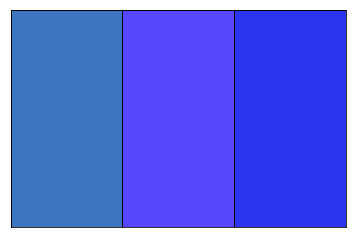

In [1425]:
global_viz2([[61, 117, 195], [86, 71, 253], [43, 53, 238]])